In [61]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool

In [62]:
data_path=None
all_variables=None
test_path=None
target=None
nthreads=1 
min_mem_size=6 
run_time=333
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [63]:
def alphabet(n):
    alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
    str=''
    r=len(alpha)-1   
    while len(str)<n:
        i=random.randint(0,r)
        str+=alpha[i]   
    return str

def set_meta_data(run_id,analysis,target,run_time,classification,scale,model,balance,balance_threshold,name,nthreads,min_mem_size):
    m_data={}
    m_data['run_id'] =run_id
    m_data['start_time'] = time.time()
    m_data['target']=target
    m_data['max_models']=model
    m_data['run_time']=run_time
    m_data['scale']=scale
    m_data['classification']=classification
    m_data['scale']=False
    m_data['balance']=balance
    m_data['balance_threshold']=balance_threshold
    m_data['project'] =name
    m_data['end_time'] = time.time()
    m_data['execution_time'] = 0.0
    m_data['nthreads'] = nthreads
    m_data['min_mem_size'] = min_mem_size
    m_data['analysis'] = analysis
    return m_data

def dict_to_json(dct,n):
    j = json.dumps(dct, indent=4)
    f = open(n, 'w')
    print(j, file=f)
    f.close()
    
def stackedensemble(mod):
    coef_norm=None
    try:
        metalearner = h2o.get_model(mod.metalearner()['name'])
        coef_norm=metalearner.coef_norm()
    except:
        pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
        if len(row['model_id'])>3:
            key=row['model_id'][0:3]
            if key in bm_algo:
                if bm_algo[key] is None:
                    bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id

def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d

def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d

def model_performance_stats(perf):
    d={}
    try:    
        d['mse']=perf.mse()
    except:
        pass      
    try:    
        d['rmse']=perf.rmse() 
    except:
        pass      
    try:    
        d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
        pass      
    try:    
        d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
        pass      
    try:    
        d['residual_deviance']=perf.residual_deviance() 
    except:
        pass      
    try:    
        d['null_deviance']=perf.null_deviance() 
    except:
        pass      
    try:    
        d['aic']=perf.aic() 
    except:
        pass      
    try:
        d['logloss']=perf.logloss() 
    except:
        pass    
    try:
        d['auc']=perf.auc()
    except:
        pass  
    try:
        d['gini']=perf.gini()
    except:
        pass    
    return d

def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
        iv = pd.read_csv(i,header=None)
    except:
        sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
        ivd[c.strip()]=dt[i].strip()
        i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
            if dct[key] not in ['real','int','enum']:                      
                targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
            if dct[key] != val:
                print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                    df[key] = df[key].asfactor() 
                except:
                    targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                    df[key] = df[key].asnumeric() 
                except:
                    targ.remove(key)                  
            if dct[key]=='real':
                try:                
                    df[key] = df[key].asnumeric()  
                except:
                    targ.remove(key)                  
    if y is None:
        y=df.columns[-1] 
    if y in targ:
        targ.remove(y)
    else:
        y=targ.pop()            
    return targ

def check_X(x,df):
    for name in x:
        if name not in df.columns:
            x.remove(name)  
    return x 

def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
        if 'BestOfFamily' in model:
            se=model
        if se is None:     
            for model in model_set:
                if 'AllModels'in model:
                    se=model           
    return se 

def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d 

In [64]:
data_path= 'car.csv'

In [65]:
df=pd.read_csv(data_path)

In [66]:
df.columns=['buying','maint','doors','persons','lug_boot','safety','class']

In [67]:
df.to_csv("car_clean.csv")

In [68]:
data_path="car_clean.csv"

In [69]:
data_path = os.path.join(os.path.abspath(os.curdir),data_path)

In [70]:
all_variables=None

In [71]:
run_id=alphabet(9)
# run_id to std out
print (run_id)

slht1Q1Um


In [72]:
server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)

In [73]:
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=6,port=port_no)

Checking whether there is an H2O instance running at http://localhost:13232..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.141-b15, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\raksh\AppData\Local\Temp\tmpbc8jyfky
  JVM stdout: C:\Users\raksh\AppData\Local\Temp\tmpbc8jyfky\h2o_raksha_started_from_python.out
  JVM stderr: C:\Users\raksh\AppData\Local\Temp\tmpbc8jyfky\h2o_raksha_started_from_python.err
  Server is running at http://127.0.0.1:13232
Connecting to H2O server at http://127.0.0.1:13232... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_raksha_xdw4jk
H2O cluster total nodes:,1
H2O cluster free memory:,5.750 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [74]:
meta_data = set_meta_data(run_id,analysis,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,nthreads,min_mem_size)
print(meta_data)

{'run_id': 'slht1Q1Um', 'start_time': 1539642097.7804172, 'target': None, 'max_models': 9, 'run_time': 333, 'scale': False, 'classification': False, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1539642097.7804172, 'execution_time': 0.0, 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [75]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [76]:
df.describe()

Rows:1727
Cols:8




,C1,buying,maint,doors,persons,lug_boot,safety,class
type,int,enum,enum,int,int,enum,enum,enum
mins,0.0,,,2.0,2.0,,,
mean,863.0,,,3.0007722007722,3.0008688097306666,,,
maxs,1726.0,,,4.0,4.0,,,
sigma,498.6862741243236,,,0.8166539469613198,1.0004343105525066,,,
zeros,1,,,0,0,,,
missing,0,0,0,432,576,0,0,0
0,0.0,vhigh,vhigh,2.0,2.0,small,med,unacc
1,1.0,vhigh,vhigh,2.0,2.0,small,high,unacc
2,2.0,vhigh,vhigh,2.0,2.0,med,low,unacc


In [77]:
y='class'

In [78]:
print(all_variables)

None


In [79]:
X = []  
if all_variables is None:
    X=get_independent_variables(df, y)  
else: 
    ivd=get_all_variables_csv(all_variables)    
    X=check_all_variables(df, ivd)


X=check_X(X,df)


# Add independent variables

meta_data['X']=X  


# impute missing values

_=impute_missing_values(df,X, scale)

In [80]:
df[y] = df[y].asfactor()

In [81]:
def check_y(y,df):
    ok=False
    C = [name for name in df.columns if name == y]
    for key, val in df.types.items():
        if key in C:
            if val in ['real','int','enum']:        
                ok=True         
    return ok, val

In [82]:
ok,val=check_y(y,df)

In [83]:
ok

True

In [84]:
val

'enum'

In [85]:
if val=='enum':
    print(df[y].levels())

[['acc', 'good', 'unacc', 'vgood']]


In [86]:
allV=get_variables_types(df)
allV

{'C1': 'int',
 'buying': 'enum',
 'maint': 'enum',
 'doors': 'int',
 'persons': 'int',
 'lug_boot': 'enum',
 'safety': 'enum',
 'class': 'enum'}

In [87]:
meta_data['variables']=allV

In [88]:
train, test = df.split_frame([0.9])

In [89]:
aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)
model_start_time = time.time()
aml.train(x=X,y=y,training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [90]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [91]:
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [92]:
aml_leaderboard_df

,model_id,mean_per_class_error,logloss,rmse,mse
0,StackedEnsemble_BestOfFamily_0_AutoML_20181015_182139,0.084032,0.098849,0.165929,0.027532
1,GBM_grid_0_AutoML_20181015_182139_model_4,0.090978,0.097603,0.169973,0.028891
2,GBM_grid_0_AutoML_20181015_182139_model_27,0.091427,0.091810,0.164923,0.027200
3,GBM_grid_0_AutoML_20181015_182139_model_39,0.095601,0.105589,0.180946,0.032741
4,GBM_grid_0_AutoML_20181015_182139_model_49,0.097187,0.079849,0.153783,0.023649
5,GBM_grid_0_AutoML_20181015_182139_model_15,0.097687,0.098312,0.169897,0.028865
6,GBM_grid_0_AutoML_20181015_182139_model_33,0.099742,0.116841,0.188604,0.035571
7,GBM_grid_0_AutoML_20181015_182139_model_44,0.103988,0.121647,0.148554,0.022068
8,StackedEnsemble_AllModels_0_AutoML_20181015_182139,0.105725,0.083789,0.150147,0.022544
9,GBM_grid_0_AutoML_20181015_182139_model_6,0.108621,0.091884,0.162994,0.026567


In [93]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [94]:
mod_best._id

'StackedEnsemble_BestOfFamily_0_AutoML_20181015_182139'

In [95]:
se=get_stacked_ensemble(model_set)

In [96]:
print(se)

StackedEnsemble_BestOfFamily_0_AutoML_20181015_182139


In [97]:
if se is not None:
    mod_best=h2o.get_model(se)

In [98]:
mod_best

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181015_182139
No model summary for this model


ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0019889134390328658
RMSE: 0.04459723577793657

ModelMetricsMultinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.013208008139794527
RMSE: 0.11492609860164282

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.027532499380325575
RMSE: 0.16592919990262586


In [99]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181015_182139
No model summary for this model


ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0019889134390328658
RMSE: 0.04459723577793657

ModelMetricsMultinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.013208008139794527
RMSE: 0.11492609860164282

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.027532499380325575
RMSE: 0.16592919990262586
<bound method ModelBase.coef_norm of >


In [100]:
bm=stackedensemble_df(aml_leaderboard_df)

In [101]:
bm

['GBM_grid_0_AutoML_20181015_182139_model_4',
 'GLM_grid_0_AutoML_20181015_182139_model_0',
 'DRF_0_AutoML_20181015_182139',
 'XRT_0_AutoML_20181015_182139',
 'DeepLearning_0_AutoML_20181015_182139']

In [102]:
#  Get best_models and coef_norm()
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
    if 'Intercept' in best_models.keys():
        del best_models['Intercept']
    bm=list(best_models.keys())
else:
    best_models={}
    bm=stackedensemble_df(aml_leaderboard_df)   
    for b in bm:   
        best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [103]:
aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]

In [104]:
aml_leaderboard_df

,model_id,mean_per_class_error,logloss,rmse,mse
0,StackedEnsemble_BestOfFamily_0_AutoML_20181015_182139,0.084032,0.098849,0.165929,0.027532
1,GBM_grid_0_AutoML_20181015_182139_model_4,0.090978,0.097603,0.169973,0.028891
37,DRF_0_AutoML_20181015_182139,0.166576,0.233635,0.232169,0.053902
47,GLM_grid_0_AutoML_20181015_182139_model_0,0.239045,0.292093,0.313387,0.098212
48,XRT_0_AutoML_20181015_182139,0.247325,0.236093,0.248804,0.061904
52,DeepLearning_0_AutoML_20181015_182139,0.346026,0.274235,0.299417,0.089651


In [105]:

# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [106]:
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

StackedEnsemble_BestOfFamily_0_AutoML_20181015_182139


In [107]:
mod_best=h2o.get_model(top)
print(mod_best._id)
print(mod_best.algo)

StackedEnsemble_BestOfFamily_0_AutoML_20181015_182139
stackedensemble


In [108]:
meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo

In [109]:
meta_data['models']=bm

In [110]:
models_path=os.path.join(run_dir,'models')
for mod in bm:
    try:   
        m=h2o.get_model(mod) 
        h2o.save_model(m, path = models_path)
    except:    
        pass

In [111]:
# GBM
 
mod,mod_id=get_model_by_algo("GBM",best_models)
if mod is not None:
    try:     
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_gbm_scoring_history.csv') 
    except:
        pass   
    try:     
        stats_gbm={}
        stats_gbm=gbm_stats(mod)
        n=run_id+'_gbm_stats.json'
        dict_to_json(stats_gbm,n)
        print(stats_gbm)
    except:
        pass

{'algo': 'gbm', 'model_id': 'GBM_grid_0_AutoML_20181015_182139_model_4', 'varimp': [('safety', 553.5850219726562, 1.0, 0.3260288677697011), ('persons', 506.49200439453125, 0.914930831382842, 0.29829386304333927), ('C1', 351.782958984375, 0.6354632893260449, 0.2071793767281804), ('maint', 101.58878326416016, 0.1835107151240411, 0.05982979067549928), ('lug_boot', 78.74455261230469, 0.14224473113760328, 0.04637588863899834), ('buying', 76.21196746826172, 0.13766985095927348, 0.04488434563427543), ('doors', 29.557918548583984, 0.053393638511491315, 0.017407867510006222)]}


In [112]:
# DeepLearning

mod,mod_id=get_model_by_algo("Dee",best_models)

In [113]:
if mod is not None:
    try:    
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_dl_scoring_history.csv') 
    except:
        pass 
    try:
        stats_dl={}
        stats_dl=dl_stats(mod)
        n=run_id+'_dl_stats.json'
        dict_to_json(stats_dl,n)
        print(stats_dl)
    except:
        pass    
    try:
        cf=mod.confusion_matrix()    
        cf_df.to_csv(run_id+'_dl_confusion_matrix.csv')
    except:
        pass

{'algo': 'deeplearning', 'model_id': 'DeepLearning_0_AutoML_20181015_182139', 'varimp': [('safety.high', 1.0, 1.0, 0.08718939269698223), ('maint.vhigh', 0.9426842331886292, 0.9426842331886292, 0.08219206579673696), ('persons', 0.8620752692222595, 0.8620752692222595, 0.07516381918257627), ('safety.low', 0.8315789103507996, 0.8315789103507996, 0.07250486017310445), ('maint.high', 0.7918141484260559, 0.7918141484260559, 0.06903779473014596), ('maint.low', 0.787296712398529, 0.787296712398529, 0.06864392222635843), ('maint.med', 0.7624334692955017, 0.7624334692955017, 0.06647611115972804), ('safety.med', 0.7585445046424866, 0.7585445046424866, 0.06613703469341162), ('lug_boot.big', 0.6838441491127014, 0.6838441491127014, 0.059623956060521), ('buying.low', 0.6690362691879272, 0.6690362691879272, 0.0583328660027501), ('lug_boot.med', 0.6470198631286621, 0.6470198631286621, 0.05641326892907261), ('C1', 0.6392287611961365, 0.6392287611961365, 0.05573396748313542), ('lug_boot.small', 0.53749579

In [114]:
# GLM

mod,mod_id=get_model_by_algo("GLM",best_models)
if mod is not None:
    try:     
        stats_glm={}
        stats_glm=glm_stats(mod)
        n=run_id+'_glm_stats.json'
        dict_to_json(stats_glm,n)
        print(stats_glm)
    except:
         pass

In [115]:
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
        cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
        cf_df=cf[0].table.as_data_frame()
        cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
        pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
        cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
        cf_df=cf[0].table.as_data_frame()
        cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
        pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

In [116]:
predictions = mod_best.predict(test)    
predictions_df=test.cbind(predictions).as_data_frame() 
predictions_df.to_csv(run_id+'_predictions.csv')

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [117]:
# Update and save meta data

meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
n=run_id+'_meta_data.json'
dict_to_json(meta_data,n)

In [118]:
meta_data

{'run_id': 'slht1Q1Um',
 'start_time': 1539642097.7804172,
 'target': None,
 'max_models': 9,
 'run_time': 333,
 'scale': False,
 'classification': False,
 'balance': False,
 'balance_threshold': 0.2,
 'project': None,
 'end_time': 1539642632.0936809,
 'execution_time': 534.3132636547089,
 'nthreads': 1,
 'min_mem_size': 6,
 'analysis': 0,
 'X': ['C1', 'doors', 'persons', 'buying', 'maint', 'lug_boot', 'safety'],
 'variables': {'C1': 'int',
  'buying': 'enum',
  'maint': 'enum',
  'doors': 'int',
  'persons': 'int',
  'lug_boot': 'enum',
  'safety': 'enum',
  'class': 'enum'},
 'model_execution_time': 530.645843744278,
 'mod_best': 'StackedEnsemble_BestOfFamily_0_AutoML_20181015_182139',
 'mod_best_algo': 'stackedensemble',
 'models': ['GBM_grid_0_AutoML_20181015_182139_model_4',
  'GLM_grid_0_AutoML_20181015_182139_model_0',
  'DRF_0_AutoML_20181015_182139',
  'XRT_0_AutoML_20181015_182139',
  'DeepLearning_0_AutoML_20181015_182139',
  'StackedEnsemble_BestOfFamily_0_AutoML_20181015_1

In [121]:
plots=aml.leaderboard

In [125]:
varImp=h2o.get_model(plots[52,"model_id"])

In [127]:
varImp.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,safety.high,1.000000,1.000000,0.087189
1,maint.vhigh,0.942684,0.942684,0.082192
2,persons,0.862075,0.862075,0.075164
3,safety.low,0.831579,0.831579,0.072505
4,maint.high,0.791814,0.791814,0.069038
5,maint.low,0.787297,0.787297,0.068644
6,maint.med,0.762433,0.762433,0.066476
7,safety.med,0.758545,0.758545,0.066137
8,lug_boot.big,0.683844,0.683844,0.059624
9,buying.low,0.669036,0.669036,0.058333


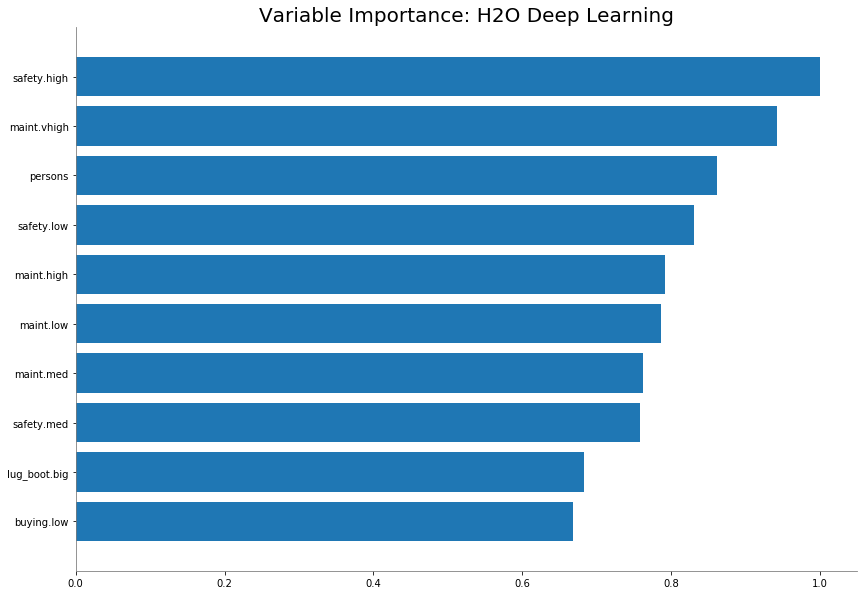

In [129]:
varImp.varimp_plot()

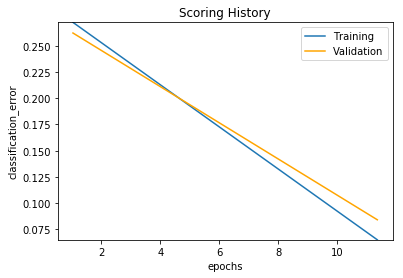

In [140]:
varImp.plot()

In [143]:
varImp.confusion_matrix

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_0_AutoML_20181015_182139


ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.05596219173676882
RMSE: 0.23656329329963433
LogLoss: 0.18207870584127683
Mean Per-Class Error: 0.17479321300044984
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



acc,good,unacc,vgood,Error,Rate
273.0,2.0,13.0,0.0,0.0520833,15 / 288
11.0,34.0,0.0,7.0,0.3461538,18 / 52
34.0,0.0,820.0,1.0,0.0409357,35 / 855
3.0,10.0,0.0,37.0,0.26,13 / 50
321.0,46.0,833.0,45.0,0.0650602,"81 / 1,245"


Top-4 Hit Ratios: 


k,hit_ratio
1,0.9349397
2,0.9943775
3,0.9991968
4,1.0



ModelMetricsMultinomial: deeplearning
** Reported on validation data. **

MSE: 0.063877915710602
RMSE: 0.25274080737111293
LogLoss: 0.20294484368045546
Mean Per-Class Error: 0.24576495351297806
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



acc,good,unacc,vgood,Error,Rate
60.0,1.0,6.0,0.0,0.1044776,7 / 67
5.0,6.0,0.0,1.0,0.5,6 / 12
10.0,0.0,211.0,0.0,0.0452489,10 / 221
1.0,2.0,0.0,6.0,0.3333333,3 / 9
76.0,9.0,217.0,7.0,0.0841424,26 / 309


Top-4 Hit Ratios: 


k,hit_ratio
1,0.9158576
2,0.9935275
3,1.0
4,1.0



ModelMetricsMultinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.08965061023534958
RMSE: 0.2994171174721806
LogLoss: 0.2742351339325952
Mean Per-Class Error: 0.34602648448043183
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



acc,good,unacc,vgood,Error,Rate
230.0,6.0,51.0,1.0,0.2013889,58 / 288
28.0,16.0,0.0,8.0,0.6923077,36 / 52
26.0,0.0,829.0,0.0,0.0304094,26 / 855
11.0,12.0,0.0,27.0,0.46,23 / 50
295.0,34.0,880.0,36.0,0.1148594,"143 / 1,245"


Top-4 Hit Ratios: 


k,hit_ratio
1,0.8851405
2,0.9751004
3,0.9927711
4,1.0


Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8851405,0.0183688,0.9076305,0.8554217,0.9076305,0.9036145,0.8514056
err,0.1148594,0.0183688,0.0923695,0.1445783,0.0923695,0.0963855,0.1485944
err_count,28.6,4.5738387,23.0,36.0,23.0,24.0,37.0
logloss,0.2742351,0.0342855,0.2160985,0.2981893,0.2889747,0.2231494,0.3447637
max_per_class_error,0.7571428,0.0991174,0.75,0.5833333,0.6666667,1.0,0.7857143
mean_per_class_accuracy,0.659216,0.0414394,0.6937965,0.699151,0.7257195,0.5915120,0.585901
mean_per_class_error,0.340784,0.0414394,0.3062035,0.3008490,0.2742805,0.4084881,0.4140990
mse,0.0896506,0.0117676,0.0699582,0.1016505,0.0880954,0.0741771,0.1143718
r2,0.8864963,0.0156475,0.9082985,0.8717036,0.8915409,0.9092459,0.8516927
rmse,0.2981351,0.0195715,0.2644962,0.3188268,0.2968086,0.2723548,0.3381890


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_classification_error
,2018-10-15 18:22:09,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2018-10-15 18:22:09,1.237 sec,186000 obs/sec,1.0457831,1,1302.0,0.4628086,0.6780953,0.7294514,0.2722892,0.4531358,0.6606239,0.7220367,0.2621359
,2018-10-15 18:22:09,1.308 sec,201828 obs/sec,11.3477912,11,14128.0,0.2365633,0.1820787,0.9293134,0.0650602,0.2527408,0.2029448,0.9135268,0.0841424


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
safety.high,1.0,1.0,0.0871894
maint.vhigh,0.9426842,0.9426842,0.0821921
persons,0.8620753,0.8620753,0.0751638
safety.low,0.8315789,0.8315789,0.0725049
maint.high,0.7918141,0.7918141,0.0690378
---,---,---,---
doors,0.3151335,0.3151335,0.0274763
buying.missing(NA),0.0,0.0,0.0
maint.missing(NA),0.0,0.0,0.0
lug_boot.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


<bound method H2OMultinomialModel.confusion_matrix of >

In [148]:
roc=varImp.model_performance()
roc.show()


ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.05596219173676882
RMSE: 0.23656329329963433
LogLoss: 0.18207870584127683
Mean Per-Class Error: 0.17479321300044984
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



acc,good,unacc,vgood,Error,Rate
273.0,2.0,13.0,0.0,0.0520833,15 / 288
11.0,34.0,0.0,7.0,0.3461538,18 / 52
34.0,0.0,820.0,1.0,0.0409357,35 / 855
3.0,10.0,0.0,37.0,0.26,13 / 50
321.0,46.0,833.0,45.0,0.0650602,"81 / 1,245"


Top-4 Hit Ratios: 


k,hit_ratio
1,0.9349397
2,0.9943775
3,0.9991968
4,1.0


predict,acc,good,unacc,vgood
unacc,0.000866648,1.82336e-05,0.999088,2.72623e-05
unacc,0.000866466,1.82153e-05,0.999088,2.72577e-05
unacc,0.00127717,3.53003e-05,0.998647,4.01343e-05
unacc,0.000871765,1.85661e-05,0.999082,2.74108e-05
unacc,0.00122566,2.98771e-05,0.998704,4.05198e-05
unacc,0.000897944,1.90879e-05,0.999053,2.98528e-05
unacc,0.00129051,3.08591e-05,0.998633,4.59316e-05
unacc,0.000867116,1.82684e-05,0.999087,2.72783e-05
unacc,0.00121806,3.40517e-05,0.99871,3.83169e-05
unacc,0.000907715,1.9436e-05,0.999043,3.01462e-05


In [119]:
#os.chdir(server_path)

In [120]:
#h2o.cluster().shutdown()